# ***Title: Campus Event Feedback Analyzer: An NLP Approach to Student Sentiment***

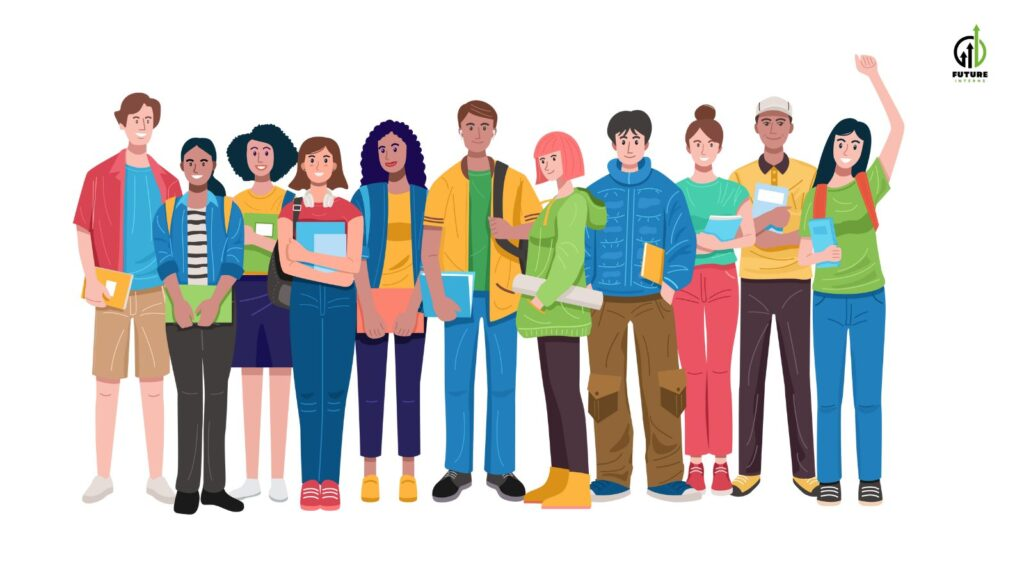
## **Description**
**Objective:**

This notebook provides a comprehensive framework for analyzing text and rating-based feedback from students after campus events. By employing basic Natural Language Processing (NLP) techniques, it aims to automatically quantify satisfaction levels, extract key themes from written comments, and identify specific areas of success and opportunities for improvement.

**Methodology:**

The analysis follows a structured pipeline:

* Data Preprocessing: Cleaning and preparing raw text feedback for analysis (tokenization, stopword removal, lemmatization).

* Sentiment Analysis: Using the VADER model to classify feedback into Positive, Negative, and Neutral categories and assign a sentiment score.

* Rating Analysis: Visualizing and interpreting numerical ratings across different event aspects (Weightage 1-5).

* Text Analytics: Generating word clouds and frequency distributions to uncover prevalent terms in both positive and negative feedback.

* Integrated Insights: Correlating textual sentiment with numerical ratings to build a holistic view of student perception.

**Expected Output:**
- The final output is a clear, data-driven report that highlights:

- The overall student satisfaction score.

- Which event aspects are rated highest and lowest.

- The most common praises and complaints mentioned by students.

- Actionable recommendations for enhancing future events.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Set style for visualizations
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **1. Data Loading and Exploration**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset
try:
  data = pd.read_csv("/content/drive/MyDrive/project/Student_Satisfaction_Survey.csv", encoding='latin-1')
except UnicodeDecodeError:
  data = pd.read_csv("/content/drive/MyDrive/project/Student_Satisfaction_Survey.csv", encoding='cp1252')

# Display the first few rows of the dataset
print("Dataset Shape:", data.shape)
print("\nColumn Names:")
print(data.columns.tolist())
print("\nFirst few rows:")
data.head()

Mounted at /content/drive
Dataset Shape: (580, 12)

Column Names:
['SN', 'Total Feedback Given', 'Total Configured', 'Questions', 'Weightage 1', 'Weightage 2', 'Weightage 3', 'Weightage 4', 'Weightage 5', 'Average/ Percentage', 'Course Name ', 'Basic Course']

First few rows:


,SN,Total Feedback Given,Total Configured,Questions,Weightage 1,Weightage 2,Weightage 3,Weightage 4,Weightage 5,Average/ Percentage,Course Name,Basic Course
0,1,1,12,How much of the syllabus was covered in the cl...,0,0,1,0,0,3.00 / 60.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
1,2,1,12,How well did the teachers prepare for the clas...,0,0,0,0,1,5.00 / 100.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
2,3,1,12,How well were the teachers able to communicate?,0,0,0,0,1,5.00 / 100.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
3,4,1,12,The teachers approach to teaching can best be...,0,0,1,0,0,3.00 / 60.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
4,5,1,12,Fairness of the internal evaluation process by...,0,0,0,1,0,4.00 / 80.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY


In [3]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Check data types
print("\nData types:")
print(data.dtypes)

Missing values in each column:
SN                      0
Total Feedback Given    0
Total Configured        0
Questions               0
Weightage 1             0
Weightage 2             0
Weightage 3             0
Weightage 4             0
Weightage 5             0
Average/ Percentage     0
Course Name             0
Basic Course            0
dtype: int64

Data types:
SN                       int64
Total Feedback Given     int64
Total Configured         int64
Questions               object
Weightage 1              int64
Weightage 2              int64
Weightage 3              int64
Weightage 4              int64
Weightage 5              int64
Average/ Percentage     object
Course Name             object
Basic Course            object
dtype: object


# **2. Data Preprocessing**

In [4]:
# First, let's handle missing values in the text feedback
data['Questions'] = data['Questions'].fillna('No feedback provided')

# Check the distribution of ratings
rating_columns = ['Weightage 1', 'Weightage 2', 'Weightage 3', 'Weightage 4', 'Weightage 5']
print("Rating columns distribution:")
for col in rating_columns:
    print(f"{col}: {data[col].notnull().sum()} responses")

Rating columns distribution:
Weightage 1: 580 responses
Weightage 2: 580 responses
Weightage 3: 580 responses
Weightage 4: 580 responses
Weightage 5: 580 responses


In [7]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

# Download necessary NLTK data if not already downloaded
try:
    nltk.data.find('tokenizers/punkt_tab/english')
except LookupError:
    nltk.download('punkt_tab')

# Apply preprocessing to the text feedback
data['Cleaned_Feedback'] = data['Questions'].apply(preprocess_text)
# Display some examples of cleaned feedback
print("Original vs Cleaned Feedback Examples:")
for i in range(3):
    print(f"Original: {data['Questions'].iloc[i][:100]}...")
    print(f"Cleaned: {data['Cleaned_Feedback'].iloc[i][:100]}...")
    print("-" * 50)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Original vs Cleaned Feedback Examples:
Original: How much of the syllabus was covered in the class?...
Cleaned: much syllabus covered class...
--------------------------------------------------
Original: How well did the teachers prepare for the classes?...
Cleaned: well teacher prepare class...
--------------------------------------------------
Original: How well were the teachers able to communicate?...
Cleaned: well teacher able communicate...
--------------------------------------------------


# **EDA**

In [25]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {data.shape}")
print("\nColumn names and data types:")
print(data.dtypes)
print("\nMissing values per column:")
print(data.isnull().sum())
print(f"\nTotal missing values: {data.isnull().sum().sum()}")

# Basic statistics for numerical columns
numerical_cols = ['Weightage 1', 'Weightage 2', 'Weightage 3', 'Weightage 4', 'Weightage 5', 'Average/ Percentage']
print("\nBasic statistics for numerical columns:")
print(data[numerical_cols].describe())

=== DATASET OVERVIEW ===
Dataset shape: (580, 17)

Column names and data types:
SN                        int64
Total Feedback Given      int64
Total Configured          int64
Questions                object
Weightage 1               int64
Weightage 2               int64
Weightage 3               int64
Weightage 4               int64
Weightage 5               int64
Average/ Percentage      object
Course Name              object
Basic Course             object
Cleaned_Feedback         object
Sentiment_Scores         object
Sentiment_Score         float64
Sentiment                object
Average_Score           float64
dtype: object

Missing values per column:
SN                      0
Total Feedback Given    0
Total Configured        0
Questions               0
Weightage 1             0
Weightage 2             0
Weightage 3             0
Weightage 4             0
Weightage 5             0
Average/ Percentage     0
Course Name             0
Basic Course            0
Cleaned_Feedback      

# **3. Sentiment Analysis**

In [8]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    return sia.polarity_scores(text)

# Apply sentiment analysis to each feedback
data['Sentiment_Scores'] = data['Cleaned_Feedback'].apply(get_sentiment_scores)

# Extract compound score for overall sentiment
data['Sentiment_Score'] = data['Sentiment_Scores'].apply(lambda x: x['compound'])

# Categorize sentiment
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['Sentiment'] = data['Sentiment_Score'].apply(categorize_sentiment)

# Display sentiment distribution
sentiment_counts = data['Sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

Sentiment Distribution:
Sentiment
Positive    319
Neutral     261
Name: count, dtype: int64


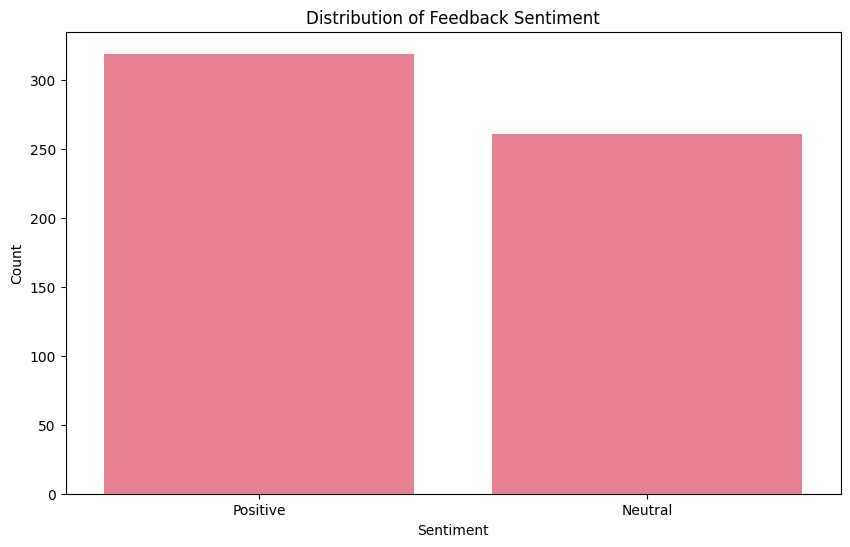

In [9]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Feedback Sentiment')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

# **4. Rating Analysis**

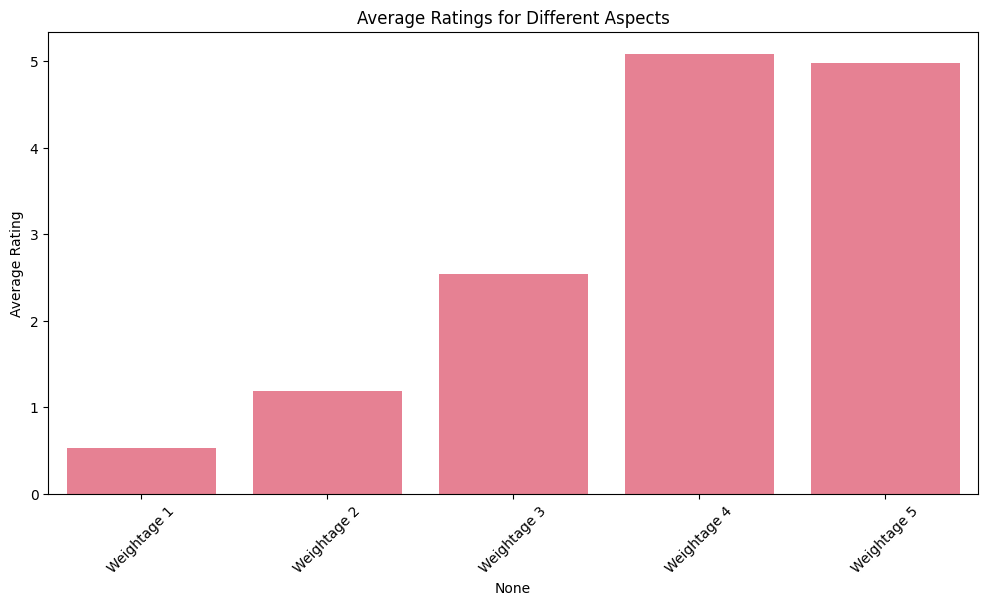

In [10]:
# Calculate average ratings
rating_data = data[rating_columns].mean()

# Visualize average ratings
plt.figure(figsize=(12, 6))
sns.barplot(x=rating_data.index, y=rating_data.values)
plt.title('Average Ratings for Different Aspects')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

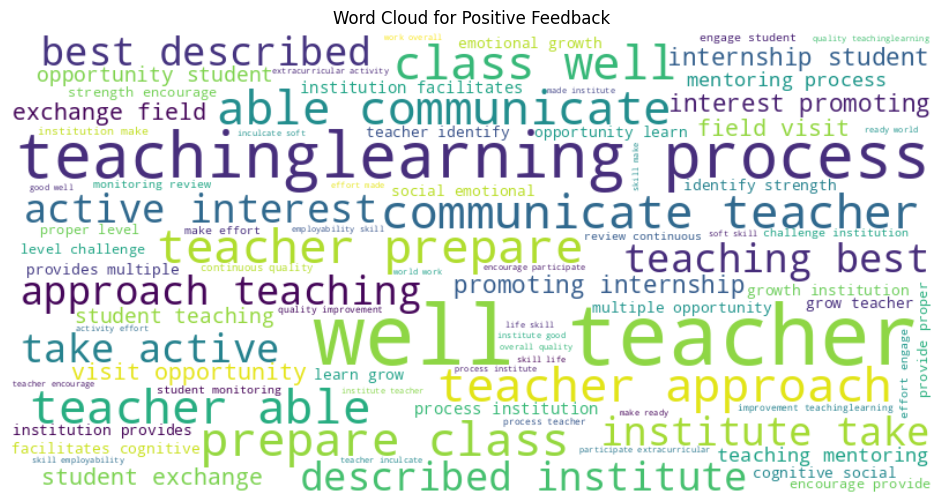

In [11]:
# Word cloud for positive feedback
positive_feedback = ' '.join(data[data['Sentiment'] == 'Positive']['Cleaned_Feedback'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_feedback)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Feedback')
plt.show()

In [12]:
# Word cloud for negative feedback
negative_feedback = ' '.join(data[data['Sentiment'] == 'Negative']['Cleaned_Feedback'])

if negative_feedback:  # Check if there is any negative feedback
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_feedback)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negative Feedback')
    plt.show()
else:
    print("No negative feedback to generate a word cloud.")

No negative feedback to generate a word cloud.


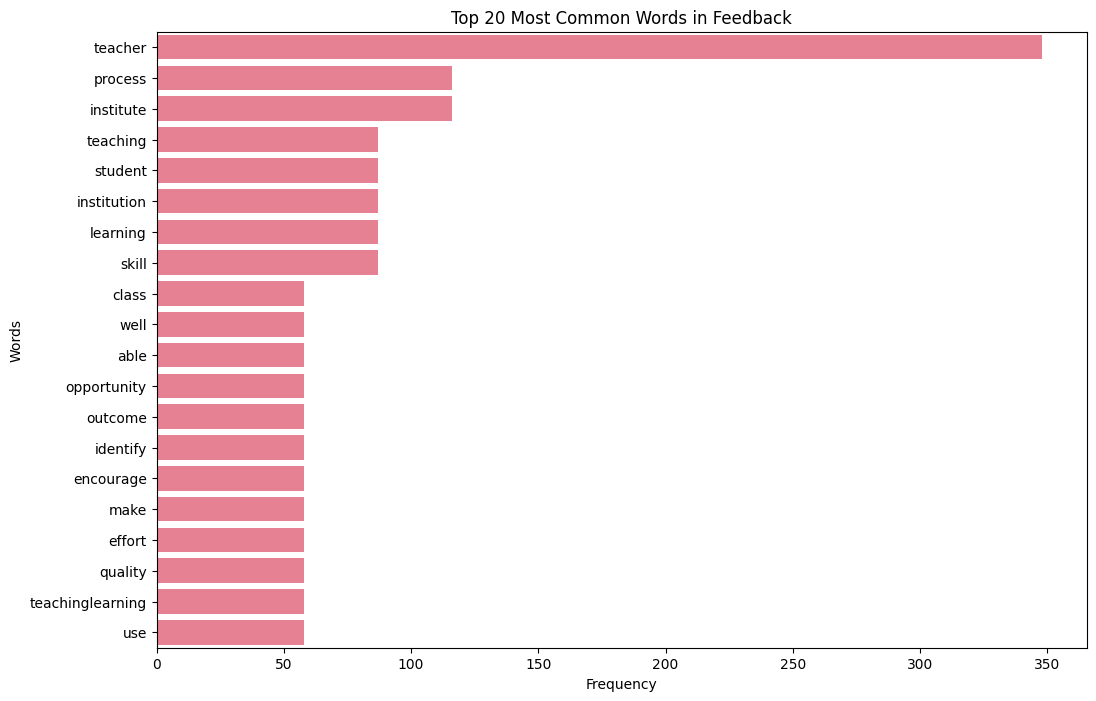

In [13]:
# Most common words in feedback
all_words = ' '.join(data['Cleaned_Feedback']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, frequencies = zip(*common_words)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(frequencies), y=list(words))
plt.title('Top 20 Most Common Words in Feedback')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# **6. Integration of Text and Rating Analysis**

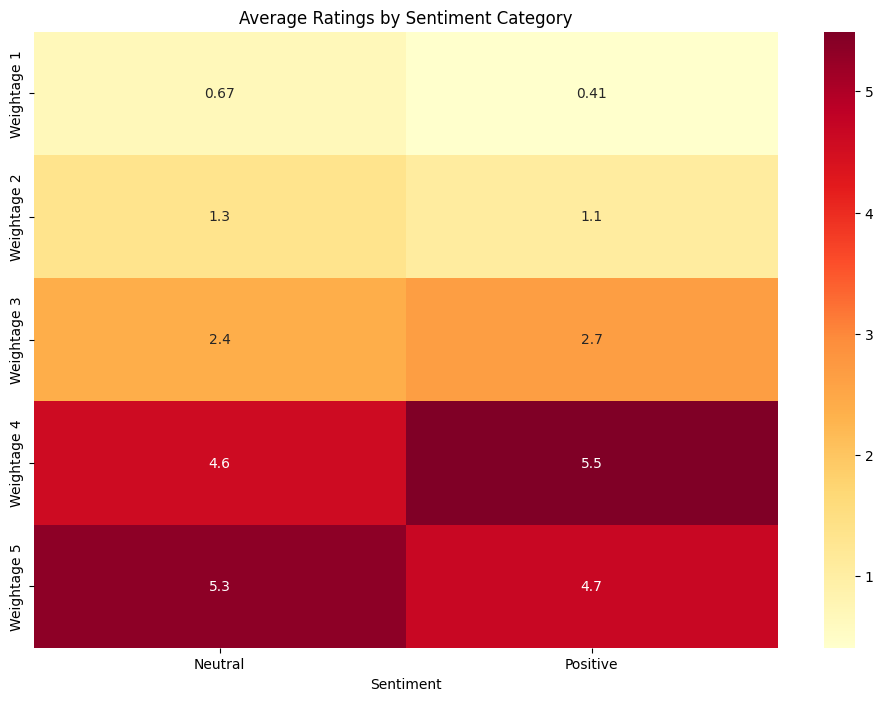

In [14]:
# Compare sentiment with average ratings
sentiment_ratings = data.groupby('Sentiment')[rating_columns].mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_ratings, annot=True, cmap='YlOrRd')
plt.title('Average Ratings by Sentiment Category')
plt.show()

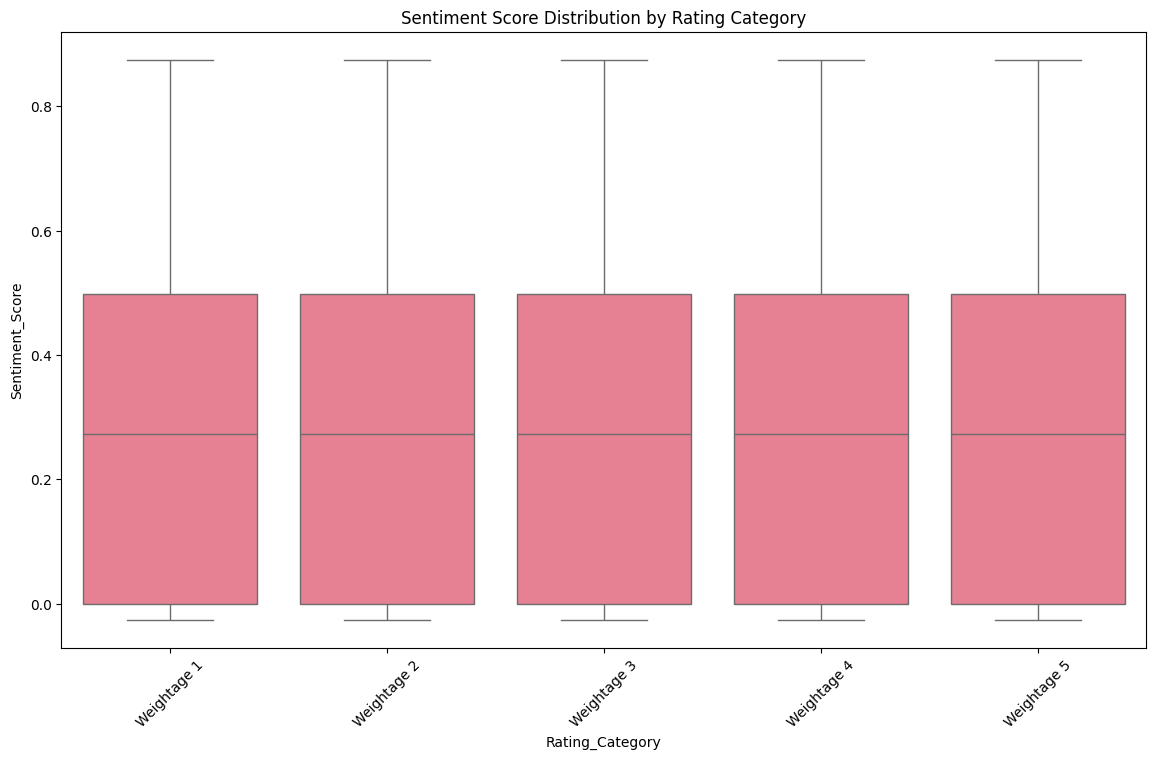

In [15]:
# Box plot of sentiment scores by rating category
melted_df = data.melt(id_vars=['Sentiment_Score'], value_vars=rating_columns,
                    var_name='Rating_Category', value_name='Rating')

plt.figure(figsize=(14, 8))
sns.boxplot(x='Rating_Category', y='Sentiment_Score', data=melted_df)
plt.title('Sentiment Score Distribution by Rating Category')
plt.xticks(rotation=45)
plt.show()

# **7. Course-Based Analysis**

In [16]:
# Check if we have course information
if 'Course Name' in data.columns and data['Course Name'].notnull().sum() > 0:
    # Average sentiment by course
    course_sentiment = data.groupby('Course Name')['Sentiment_Score'].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    course_sentiment.plot(kind='bar')
    plt.title('Average Sentiment Score by Course')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.show()

    # Count feedback by course
    course_counts = data['Course Name'].value_counts()

    plt.figure(figsize=(12, 8))
    course_counts.plot(kind='bar')
    plt.title('Number of Feedback Responses by Course')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No course information available for analysis.")

No course information available for analysis.


# **8. Key Insights and Recommendations**

In [18]:
# Calculate overall satisfaction score
if 'Average/ Percentage' in data.columns:
    # Extract the numeric part before '/' and convert to float
    data['Average_Score'] = data['Average/ Percentage'].apply(lambda x: float(x.split('/')[0].strip()) if isinstance(x, str) and '/' in x else None)
    overall_satisfaction = data['Average_Score'].mean()
else:
    overall_satisfaction = data[rating_columns].mean().mean()

print(f"Overall Satisfaction Score: {overall_satisfaction:.2f}/5.00")

Overall Satisfaction Score: 3.84/5.00


In [17]:
# Identify areas with lowest ratings
lowest_rated = data[rating_columns].mean().sort_values().index[0]
print(f"Area needing most improvement: {lowest_rated}")

Area needing most improvement: Weightage 1


In [19]:
# Most common issues from negative feedback
negative_text = ' '.join(data[data['Sentiment'] == 'Negative']['Cleaned_Feedback'])
negative_words = [word for word in negative_text.split() if len(word) > 3]  # Filter short words
negative_freq = Counter(negative_words).most_common(10)

print("\nTop issues mentioned in negative feedback:")
for word, count in negative_freq:
    print(f"- {word}: {count} mentions")


Top issues mentioned in negative feedback:


In [21]:
# Most appreciated aspects from positive feedback
positive_text = ' '.join(data[data['Sentiment'] == 'Positive']['Cleaned_Feedback'])
positive_words = [word for word in positive_text.split() if len(word) > 3]  # Filter short words
positive_freq = Counter(positive_words).most_common(10)

print("\nTop appreciated aspects in positive feedback:")
for word, count in positive_freq:
    print(f"- {word}: {count} mentions")


Top appreciated aspects in positive feedback:
- teacher: 174 mentions
- institute: 87 mentions
- student: 87 mentions
- process: 87 mentions
- institution: 87 mentions
- skill: 87 mentions
- well: 58 mentions
- teaching: 58 mentions
- opportunity: 58 mentions
- encourage: 58 mentions


# **9. Exporting Results**

In [22]:
# Create a summary dataframe
summary_data = pd.DataFrame({
    'Total_Responses': [len(data)],
    'Positive_Feedback_Count': [len(data[data['Sentiment'] == 'Positive'])],
    'Negative_Feedback_Count': [len(data[data['Sentiment'] == 'Negative'])],
    'Neutral_Feedback_Count': [len(data[data['Sentiment'] == 'Neutral'])],
    'Overall_Satisfaction': [overall_satisfaction],
    'Area_Needing_Improvement': [lowest_rated]
})

In [23]:
print(summary_data.head())

   Total_Responses  Positive_Feedback_Count  Negative_Feedback_Count  \
0              580                      319                        0   

   Neutral_Feedback_Count  Overall_Satisfaction Area_Needing_Improvement  
0                     261              3.842793              Weightage 1  


In [24]:
# Save summary and detailed analysis
summary_data.to_csv('feedback_summary.csv', index=False)
data.to_csv('detailed_analysis.csv', index=False)

print("Analysis completed and results saved!")

Analysis completed and results saved!
